**Goal ?**

goal would be to enable the model to learn meaningful and generalizable visual representations of images without requiring labeled data

**Self-supervised learning**:  refers to a deep learning approach in which a model is initially trained on unlabeled data. During this process, the data generates its own labels, which are then utilized as ground truths in future training iterations.



**Imports**

In [1]:
import os

import kagglehub
import random

import numpy as np
from PIL import Image

from matplotlib import pyplot as plt

from sklearn.manifold import TSNE

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision.transforms.functional as F
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Download latest version
path = kagglehub.dataset_download("zaiyankhan/15scene-dataset")

print("Path to dataset files:", path)

100%|██████████| 165M/165M [00:08<00:00, 19.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/zaiyankhan/15scene-dataset/versions/1


**Data Processing**

In [4]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
# walk_through_dir(path)

In [6]:
path

'/root/.cache/kagglehub/datasets/zaiyankhan/15scene-dataset/versions/1'

In [7]:
dataset_path = os.path.join(path, "15-Scene")

In [8]:
# simple transforms
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [9]:
# create dataset
ImagesDataset = ImageFolder(root=dataset_path, transform=simple_transform )

# #DataLoader
# ImageDataLoader = DataLoader(dataset=ImagesDataset, batch_size=32, shuffle=True)

In [10]:
len(ImagesDataset)

4485

In [11]:

# Define the split ratios
train_size = int(0.999 * len(ImagesDataset))
test_size = len(ImagesDataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(ImagesDataset, [train_size, test_size])

In [12]:
#DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=2, shuffle=False, num_workers=2, pin_memory=True)

In [13]:
len(train_loader), len(test_loader)

(280, 3)

In [14]:
# Test the DataLoader
for images, _ in train_loader:
  print('Frist batch data', images.shape)
  break

Frist batch data torch.Size([16, 3, 224, 224])


show random imange

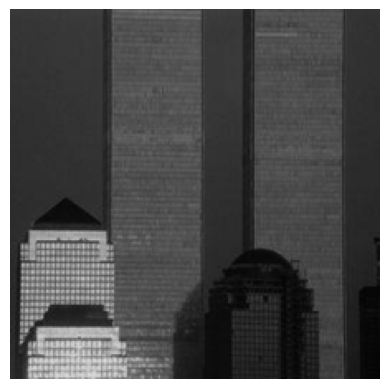

In [15]:
# Choose a random image from the dataset
random_idx = random.randint(0, len(train_dataset) - 1)
image, label = train_dataset[random_idx]  # Get the image and label

# Convert the image tensor to a format suitable for display
image = image.permute(1, 2, 0)  # Rearrange dimensions from (C, H, W) to (H, W, C)

# Plot the image
plt.imshow(image)
plt.axis("off")
plt.show()


**Model**

In [16]:
class SimpleRotationCNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )

    self.classifier = nn.Sequential(
        nn.Linear(128 * 28 * 28, 256),
        nn.ReLU(),
        nn.Linear(256, 15)
    )
  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [17]:
model = SimpleRotationCNN().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**Self-Supervised Rotation Prediction Loop:**

When you rotate an image by 90 degrees (or any other angle you choose, like 0°, 180°, or 270°), you assign a corresponding label to indicate the applied rotation. For example:

0° rotation → Label: 0

90° rotation → Label: 1

180° rotation → Label: 2

270° rotation → Label: 3

In [18]:
def get_rotation_label(angle):
    if angle == 0:
        return 0
    elif angle == 90:
        return 1
    elif angle == 180:
        return 2
    elif angle == 270:
        return 3
    else:
        raise ValueError("Invalid angle. Angle must be one of [0, 90, 180, 270].")


During training, the model learns to predict these labels based on the visual patterns it observes in the rotated images. Here's a simplified step-by-step process:

**Apply Rotation:**

Rotate the image by a random angle (e.g., 90°).

**Assign Label:**

Add the corresponding label to the image (e.g., 1 for 90°).

**Train the Model:**

Use these labeled images (original + rotated) to train a model to predict the rotation angle.

**Learn Features:**

The model, by solving this rotation prediction task, learns valuable features like edges, orientation, and spatial relationships, which can later transfer to other tasks.

In [19]:
num_epochs = 10

for epoch in range(num_epochs):
  running_loss = 0.0
  for step, (images, _ )in enumerate(test_loader):
    rotated_images = []
    rotated_labels = []

    for img in images:
      angle = random.choice([0, 90, 180, 270])
      rotated_img = F.rotate(img, angle)
      rotated_images.append(rotated_img)
      rotated_labels.append(get_rotation_label(angle))

    # convert to tensors
    rotated_images = torch.stack(rotated_images)
    rotated_labels = torch.tensor(rotated_labels)

    # move tensors to device
    rotated_images = rotated_images.to(device)
    rotated_labels = rotated_labels.to(device)

    # Forward pass
    outputs = model(rotated_images)
    loss = loss_fn(outputs, rotated_labels)

    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(test_loader)}")



Epoch 1/10, Loss: 2.03898032506307
Epoch 2/10, Loss: 2.00274395942688
Epoch 3/10, Loss: 2.338653484980265
Epoch 4/10, Loss: 1.4911652604738872
Epoch 5/10, Loss: 1.5755356550216675
Epoch 6/10, Loss: 2.1946877241134644
Epoch 7/10, Loss: 1.5116371313730876
Epoch 8/10, Loss: 0.7946678598721822
Epoch 9/10, Loss: 1.233284831047058
Epoch 10/10, Loss: 1.186172087987264


**Conculsion**

Since rotation prediction is a pretext task, the primary goal isn't just the task itself but the quality of the learned features. Here are some common ways to evaluate your SSL rotation model

Use the Model as a downstream task:

Use the trained model as a feature extractor or initialize it for:

Image Classification: Evaluate its performance on a classification task using a labeled dataset like CIFAR-10 or ImageNet.

Object Detection or Segmentation: Fine-tune the model for these tasks to see how well the features transfer.

**Visualization of Representations**

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


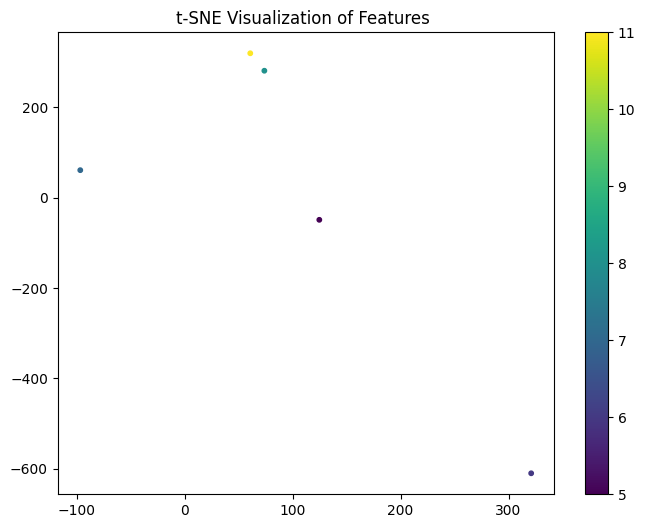

In [28]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Assuming 'model' is your trained network, 'device' is your device (CPU/GPU),
# and 'test_loader' is a DataLoader for your test dataset.
model.eval()
features = []
rotation_labels = []  # Renamed for clarity

with torch.no_grad():
    for images, labels_batch in test_loader:
        # If the test_loader is for self-supervised rotation prediction,
        # you likely generate rotation labels on the fly. Replace the logic below
        # with your own rotation augmentation and label derivation.
        outputs = model(images.to(device))

        # Store the computed features
        features.append(outputs.cpu().numpy())

        # Here, we're assuming 'labels_batch' contains your rotation labels.
        # If not, replace with the proper extraction method.
        rotation_labels.append(labels_batch.numpy())

# Concatenate all batches
features = np.concatenate(features, axis=0)
rotation_labels = np.concatenate(rotation_labels, axis=0)

# Subsample the features and labels to reduce RAM usage
subsample_size = 10000  # Adjust based on your RAM capacity and needs.
if features.shape[0] > subsample_size:
    indices = np.random.choice(features.shape[0], subsample_size, replace=False)
    features = features[indices]
    rotation_labels = rotation_labels[indices]


# Run t-SNE on the PCA-reduced features
tsne = TSNE(n_components=2, perplexity=1, n_iter=250, random_state=42)
reduced_features = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=rotation_labels, cmap='viridis', s=10)
plt.colorbar()
plt.title("t‑SNE Visualization of Features ")
plt.show()

